### 0. Codeblock für Libraries

In [ ]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install mpl_toolkits
!{sys.executable} -m pip install qdrant-client
!{sys.executable} -m pip install infisicalsdk
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install networkx

#### Python Skript zur Visualisierung von HNSW:

### Schritt 1: Generierung zufälliger Vektoren

Im ersten Schritt erzeugen wir eine Menge von zufälligen zweidimensionalen Vektoren. Diese dienen als Beispielpunkte im Raum, um die Funktionsweise des HNSW-Algorithmus anschaulich zu machen. Der HNSW-Algorithmus funktioniert mit beliebig vielen Dimensionen, aber zweidimensionale Vektoren sind anschaulicher.

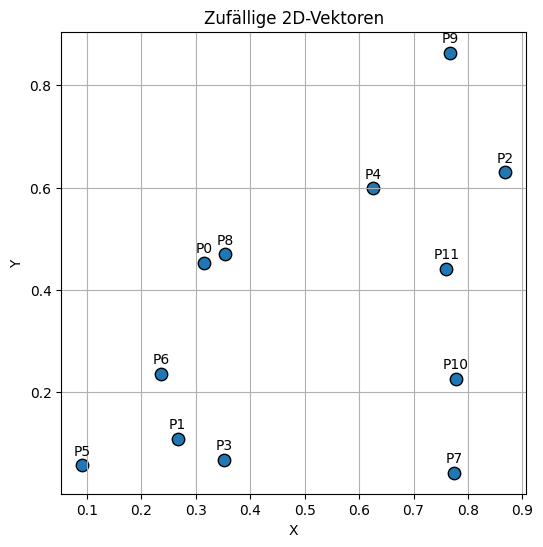

In [3]:
# 1. Zufällige 2D-Vektoren erzeugen und anzeigen
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import cdist

n_vektoren = 12 # Anzahl der Vektoren
np.random.seed(420) # Seed für Reproduzierbarkeit
vektoren = np.random.rand(n_vektoren, 2) # zufällige 2D-Vektoren in einer Liste generieren

# Vektoren in einem einfachen 2D-Plot darstellen
plt.figure(figsize=(6, 6))
plt.scatter(x=vektoren[:, 0], y=vektoren[:, 1], s=80, c="tab:blue", edgecolors="k")
for i, v in enumerate(vektoren):
    plt.text(v[0], v[1]+0.02, f"P{i}", fontsize=10, ha="center")
    
# Achsen und Titel hinzufügen
plt.title("Zufällige 2D-Vektoren")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()

### Schritt 2: Zuweisung der Ebenen (Levels)

Jeder Vektor wird nach dem Prinzip des HNSW-Algorithmus zufällig einer oder mehreren Ebenen zugeordnet. Die Wahrscheinlichkeit, auf eine höhere Ebene zu gelangen ist in dem Beispiel 50%. Dies bildet die hierarchische Struktur des HNSW-Graphen nach.

In [4]:
# 2. Für jeden Punkt bestimmen, bis zu welcher Ebene er übernommen wird

# Nochmal Seed setzen für Reproduzierbarkeit und nochmal 12 zahlen generieren, damit die Ausgabe gleich bleibt. 
# Ansonsten würden die Punkte bei jedem Lauf anders aussehen, abhängig davon ob der davorige Codeblock ausgeführt wurde oder nicht.
np.random.seed(420)  
np.random.rand(n_vektoren, 2)  # zufällig 24 seeds nutzen, damit die Ausgabe gleich bleibt

p = 0.5 # Wahrscheinlichkeit, dass ein Vektor von einer Ebene in die nächste übernommen wird

# durch alle Vektoren iterieren und die maximale Ebene bestimmen
max_levels = np.ones(n_vektoren, dtype=int)
for i in range(n_vektoren):
    lvl = 1
    while lvl < 3 and np.random.rand() < p:
        lvl += 1
    max_levels[i] = lvl

### Schritt 3: Übersicht der Ebenenzuordnung

Wir geben eine tabellarische Übersicht aus, die zeigt, auf welchen Ebenen (Levels) die einzelnen Vektoren vertreten sind. Dies verdeutlicht die Verteilung der Punkte im hierarchischen Graphen.

In [5]:
# Tabellarische Ausgabe: Punktnummer und Ebene
print("Punkt  | Ebene")
print("--------------")
for i, lvl in enumerate(max_levels):
    ebenen = ", ".join(str(e) for e in range(1, lvl + 1))
    print(f"P{i:<3}  | {ebenen}")

Punkt  | Ebene
--------------
P0    | 1, 2
P1    | 1, 2, 3
P2    | 1, 2, 3
P3    | 1, 2
P4    | 1
P5    | 1
P6    | 1
P7    | 1
P8    | 1
P9    | 1, 2, 3
P10   | 1, 2
P11   | 1, 2


### Zweck der Plot-Funktion

Die Plot-Funktion dient dazu, die Struktur des HNSW-Graphen anschaulich darzustellen. Sie visualisiert die Vektoren in ihren jeweiligen Ebenen (Levels) im dreidimensionalen Raum. Durch die farbliche Unterscheidung der Ebenen und die Darstellung der Verbindungen zwischen den Punkten wird die hierarchische Organisation des Graphen deutlich.  
So erhält man ein intuitives Verständnis dafür, wie die Vektoren im HNSW verteilt sind und wie die Navigation zwischen den Ebenen funktioniert. Die Visualisierung unterstützt dabei, die Funktionsweise und Vorteile des HNSW-Algorithmus besser

In [1]:
# Funktion zum Plotten der HNSW-Struktur mit den Vektoren und optional einem Query-Vektor
def plot_hnsw(vektoren, max_levels, query_vec=None):
    farben = {1: "tab:blue", 2: "tab:orange", 3: "tab:green"}
    labels = {1: "Straßenbahn (Ebene 1)", 2: "ICE (Ebene 2)", 3: "Flugzeug (Ebene 3)"}

    fig = plt.figure(figsize=(11, 8))
    ax = fig.add_subplot(111, projection='3d')

    plotted_labels = set()
    for i, v in enumerate(vektoren):
        for lvl in range(1, max_levels[i]+1):
            label = labels[lvl] if lvl not in plotted_labels else None
            ax.scatter(v[0], v[1], lvl, c=farben[lvl], s=90, edgecolors='k', alpha=0.85, label=label) 
            ax.text(v[0], v[1], lvl+0.05, f'P{i}', fontsize=9)
            if lvl > 1:
                ax.plot([v[0], v[0]], [v[1], v[1]], [lvl-1, lvl], c='gray', linewidth=1.5, alpha=0.4)
            plotted_labels.add(lvl)

    # Verbindungen zu nächsten Nachbarn (einfaches Beispiel: 2 NNs)
    for lvl in [1, 2, 3]:
        idx = np.where(max_levels >= lvl)[0]
        if len(idx) < 2:
            continue
        coords = np.column_stack((vektoren[idx], np.full(len(idx), lvl)))
        dists = cdist(coords, coords)
        np.fill_diagonal(dists, np.inf)
        connected = set()
        for i, i_global in enumerate(idx):
            nn_idx = np.argsort(dists[i])[:2]
            for j in nn_idx:
                j_global = idx[j]
                key = tuple(sorted((i_global, j_global, lvl)))
                if key not in connected:
                    ax.plot(
                        [vektoren[i_global, 0], vektoren[j_global, 0]],
                        [vektoren[i_global, 1], vektoren[j_global, 1]],
                        [lvl, lvl],
                        c=farben[lvl], linewidth=1.2, alpha=0.45
                    )
                    connected.add(key)

    # Hilfsebenen
    xlim = (np.min(vektoren[:, 0]) - 0.1, np.max(vektoren[:, 0]) + 0.1)
    ylim = (np.min(vektoren[:, 1]) - 0.1, np.max(vektoren[:, 1]) + 0.1)
    x = np.linspace(*xlim, 10)
    y = np.linspace(*ylim, 10)
    x, y = np.meshgrid(x, y)

    for lvl in [1, 2, 3]:
        z = np.full_like(x, lvl)
        ax.plot_surface(x, y, z, alpha=0.1, color=farben[lvl], linewidth=0, antialiased=True)

    # Optional: Query-Vektor
    if query_vec is not None:
        for lvl in [1, 2, 3]:
            ax.scatter(query_vec[0], query_vec[1], lvl, c='red', s=90, edgecolors='k', label='Query' if lvl == 1 else None)
            ax.text(query_vec[0], query_vec[1], lvl+0.08, 'Query', fontsize=11, color='red', weight='bold')

    # Formatierung
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Ebene')
    ax.set_zticks([1, 2, 3])
    ax.set_zticklabels(['Straßenbahn', 'ICE', 'Flugzeug'])
    ax.set_title('HNSW (Visualisierung von 2D-Vektoren über 3 Ebenen)', fontsize=14)
    ax.view_init(elev=17, azim=-45)

    # Doppelte Labels vermeiden
    handles, handle_labels = ax.get_legend_handles_labels()
    unique = dict(zip(handle_labels, handles))
    ax.legend(unique.values(), unique.keys())

    plt.show()

### Schritt 4: Visualisierung des HNSW-Graphen

Im nächsten Schritt visualisieren wir die Vektoren und ihre Ebenenzuordnung in einem 3D-Plot. Die Ebenen werden als z-Achse dargestellt, sodass die hierarchische Struktur des HNSW-Algorithmus sichtbar wird.

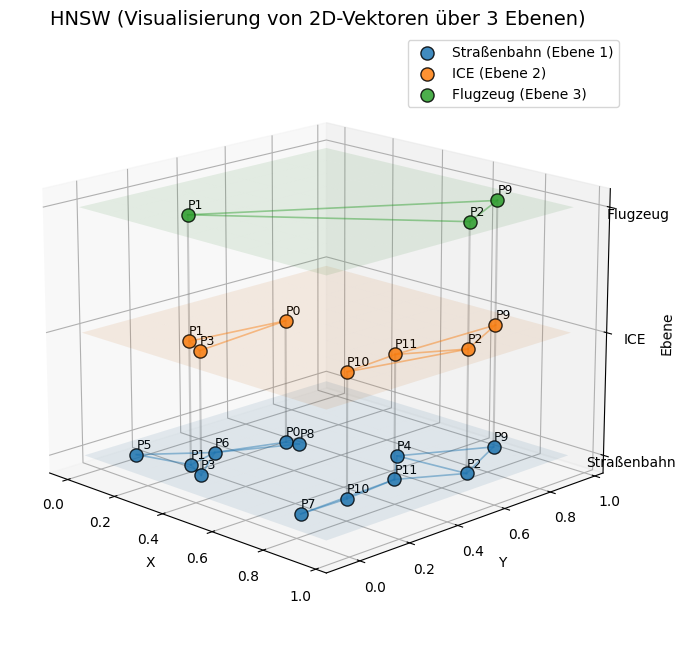

In [ ]:
# 4. HNSW-Struktur plotten
plot_hnsw(vektoren, max_levels)

### Schritt 5: Einfügen eines Query-Vektors

Um die Suche im HNSW-Graphen zu demonstrieren, fügen wir einen zusätzlichen Query-Vektor ein. Dieser wird im Plot hervorgehoben und symbolisiert den Startpunkt einer Ähnlichkeitssuche im Graphen.

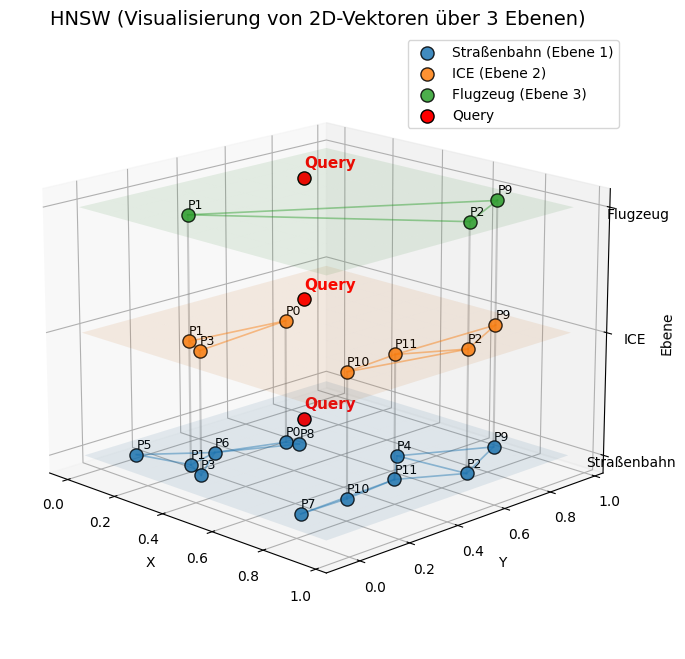

In [ ]:
# 5. Query-Vektor erzeugen und im 3D-Plot einbinden
query_vector = np.array([0.2, 0.65])  # Beispiel-Query-Vektor
plot_hnsw(vektoren, max_levels, query_vec=query_vector)

### Wie findet HNSW den ähnlichsten Vektor zum Query? (Beispiel: Start bei P2)

Beim HNSW-Algorithmus beginnt die Suche nach dem ähnlichsten Vektor zum Query-Vektor auf der **höchsten Ebene** des Graphen – in unserem Beispiel nehmen wir an, dass der Startpunkt der Knoten **P2** ist.

**Ablauf der Suche:**

1. **Start auf höchster Ebene:**  
   Die Suche startet bei P2 auf der höchsten Ebene, auf der P2 vertreten ist.  
   Auf dieser Ebene werden die Nachbarn von P2 betrachtet. Der Algorithmus prüft, ob einer dieser Nachbarn dem Query-Vektor näher ist als P2 selbst (gemessen z. B. mit euklidischer Distanz oder Kosinus-Ähnlichkeit).

2. **Greedy Search:**  
   Solange ein Nachbar existiert, der dem Query näher ist als der aktuelle Punkt, springt der Algorithmus zu diesem Nachbarn und wiederholt den Vergleich.  
   Sobald kein besserer Nachbar mehr gefunden wird, ist ein lokales Minimum erreicht.

3. **Abstieg in die nächste Ebene:**  
   Von diesem lokalen Minimum aus wechselt der Algorithmus eine Ebene tiefer.  
   Dort wiederholt sich das Vorgehen: Unter den Nachbarn auf dieser Ebene wird wieder derjenige gesucht, der dem Query am nächsten ist.

4. **Feinsuche auf der untersten Ebene:**  
   Auf der untersten Ebene (Level 1) sind alle Vektoren vertreten.  
   Hier wird die Suche lokal verfeinert, indem die Nachbarn des aktuellen Knotens durchsucht werden, bis der ähnlichste Vektor gefunden ist.

**Beispiel:**  
- Angenommen für unsere Suche ist der Startpunkt P2
- Von diesem ist P1 näher an dem Query-Vektor als P2. Also gehen wir zu P1 weiter.
- Von P1 gibt es keinen näheren Vektor in dieser Ebene, also gehen wir eine Ebene tiefer.
- In der nächsten Ebene ist P0 näher an dem Query-Vektor als P1 -> wir gehen zu P0 weiter und finden keinen weiteren näheren Vektor.
- In der letzten Ebene ist auch kein anderer Vektor näher als P0, daher ist P0 der ähnlichste Vektor zum Query-Vektor

**Vorteil:**  
Durch dieses hierarchische, greedy Vorgehen muss der Algorithmus nicht alle Vektoren durchsuchen, sondern kann mit wenigen Sprüngen sehr effizient den ähnlichsten 